1. Data Collection

1.1 Import Library

In [16]:
#import library
import sys
import os
import numpy as np # type: ignore
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
sys.path.append('../scripts')
import Preprocessing as dp
import quantitative_analysis as qan
import EDA as eda
import sentiment_analysis as san

1.2 Load dataset

In [17]:
# Load news and stock data
news_data = dp.load_data("../data/raw_analyst_ratings.csv")
stock_data = dp.load_data("../data/AMZN_historical_data.csv")

In [18]:
news_data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [19]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,0.0,0.0
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,0.0,0.0
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000,0.0,0.0
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000,0.0,0.0
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000,0.0,0.0


Date Conversion

In [20]:
# Convert 'date' column in news data and 'Date' column in stock data to datetime
news_data = dp.convert_date(news_data, column_name='date')
stock_data = dp.convert_date(stock_data, column_name='Date')

In [21]:
# Filter stock data to match the date range of news data
start_date = news_data['date'].min()
end_date = news_data['date'].max()
stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]


In [22]:
# Sentiment analysis
news_data['sentiment_score'] = news_data['headline'].apply(san.get_sentiment_score)
news_data['sentiment'] = news_data['sentiment_score'].apply(san.categorize_sentiment)


In [23]:
# Calculate daily returns for stock
stock_data['daily_return'] = stock_data['Close'].pct_change()

# Rename columns to avoid conflicts
news_data.rename(columns={'date': 'Date'}, inplace=True)

In [24]:
# Merge news data with stock data on Date
combined_data = pd.merge(stock_data, news_data, on='Date', how='left')


In [25]:
# Aggregate sentiment scores by date
daily_sentiment = combined_data.groupby('Date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score': 'average_sentiment_score'}, inplace=True)


In [26]:
# Merge aggregated sentiment with combined data
final_data = pd.merge(combined_data, daily_sentiment, on='Date', how='left')
final_data = final_data[['Date', 'average_sentiment_score', 'Close', 'daily_return']]
final_data.head()

,Date,average_sentiment_score,Close,daily_return
0,2009-02-17,NaN,3.0835,NaN
1,2009-02-18,NaN,3.1175,0.011026
2,2009-02-19,NaN,3.0975,-0.006415
3,2009-02-20,NaN,3.1930,0.030831
4,2009-02-23,NaN,3.0855,-0.033667


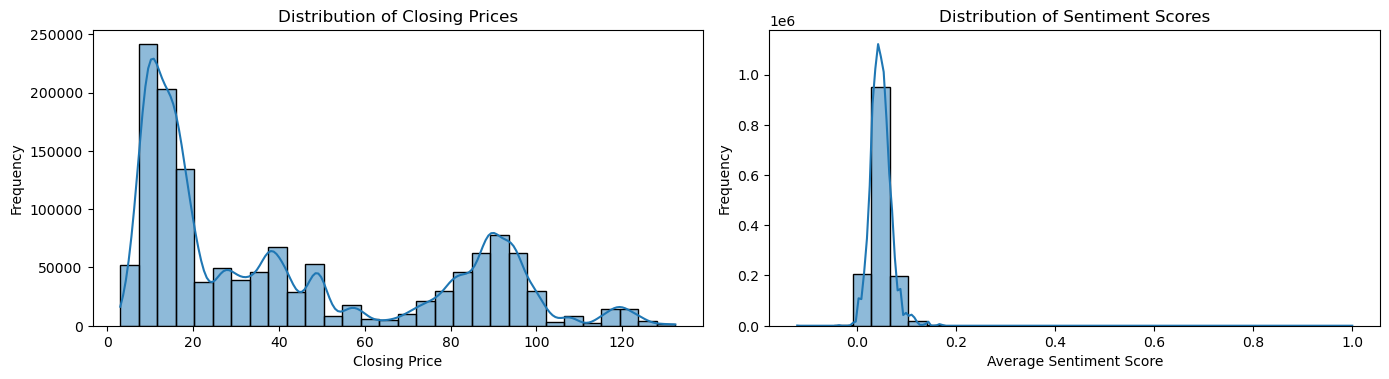

In [27]:
# Data visualization
eda.plot_distributions(final_data)

In [28]:
# Calculate correlation between sentiment and daily return
correlation_return = final_data[['average_sentiment_score', 'daily_return']].corr().iloc[0, 1]
print(f"Correlation between sentiment and daily return: {correlation_return}")


Correlation between sentiment and daily return: 0.053228214838101404


In [29]:
# Calculate correlation between sentiment and closing price
correlation_close = final_data[['average_sentiment_score', 'Close']].corr().iloc[0, 1]
print(f"Correlation between sentiment and closing price: {correlation_close}")


Correlation between sentiment and closing price: -0.21523169130082745


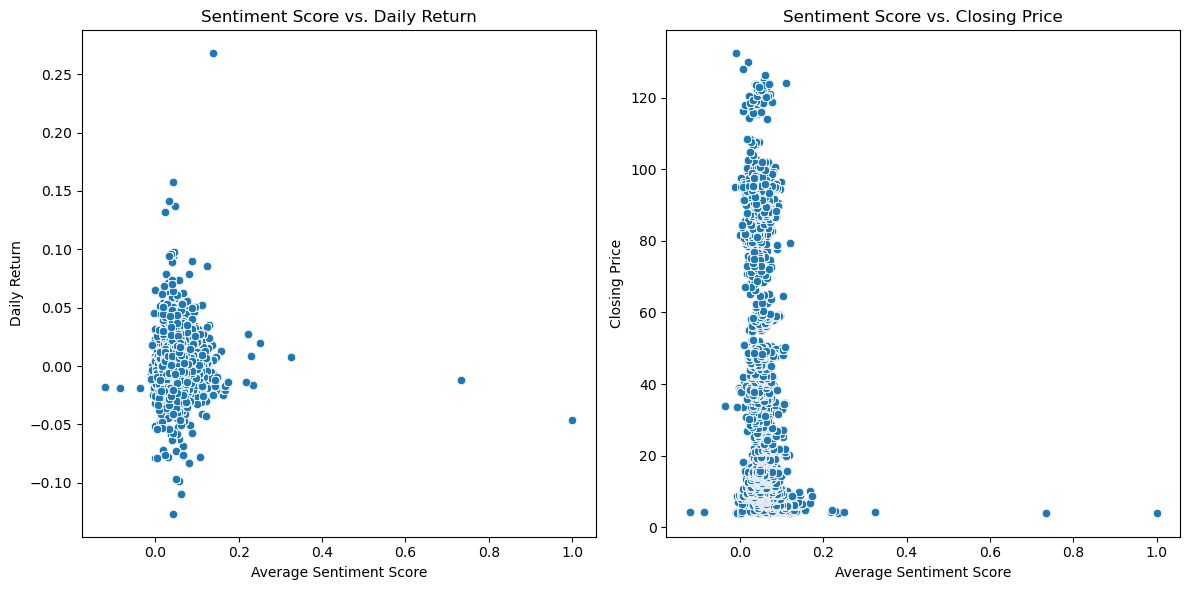

In [30]:
# Scatter plot for sentiment score vs. daily return
eda.plot_scatter(final_data)

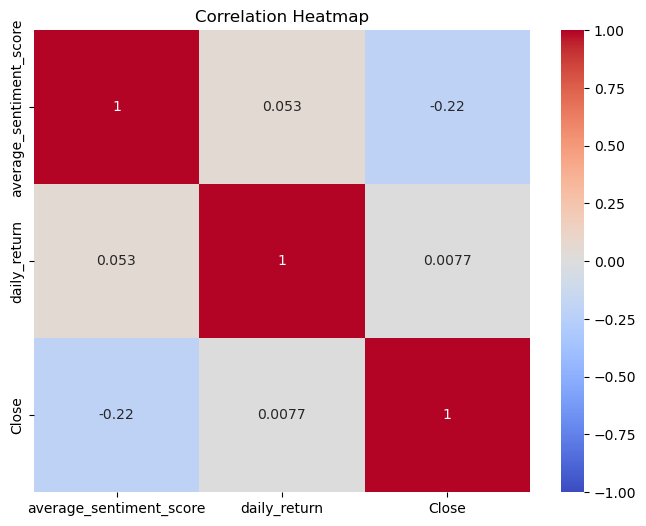

In [31]:
# Compute correlation matrix
eda.plot_heatmap(final_data)